# Purpose of this notebook

This notebook is to replicate the Lind paper as we did not do this in the previous notebooks. In particular, we want to look at 

# import the files and functions

In [1]:
# import packages and functions
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import pandas as pd  # For rolling mean

%run /home/mmurakami/crios_backups/an_helper_functions/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [2]:
path = "/home/mmurakami/crios_backups/ASTE_270/Pemberton_BarentsSpaper/ASTE_figs/figs/"

In [3]:
dirIn_new = "/scratch3/atnguyen/aste_270x450x180/run_c68v_adxOFF_20022023_capxxN50_it0062_pk0000000007_bro/diags/BUDG/"

In [4]:
# # load the landmask
hfac = mygrid['hFacC']
landmsk = hfac[0]
landmsk[np.isnan(landmsk)] = 2
landmsk[landmsk == 1] = np.nan

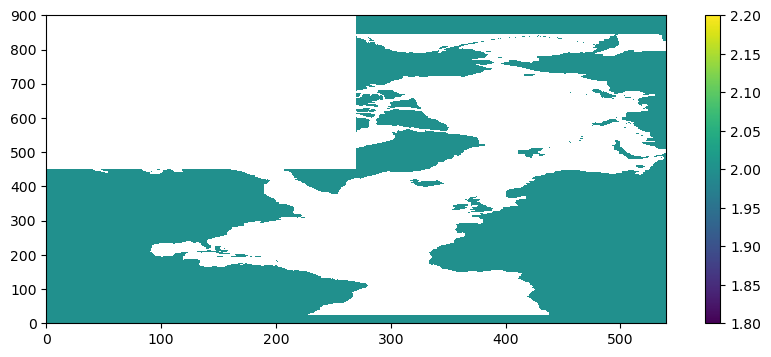

In [5]:
plt.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0])
plt.colorbar()

In [6]:
mymsk = np.load('mask_Lind.npz')
mymsk = mymsk['msk1']
mask = mymsk

Text(440, 430, 'Mask: 76.25°N - 78.5°N\n27°E - 41°E')

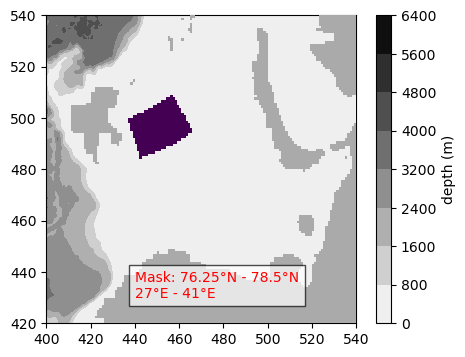

In [7]:
a = np.full(mskBasin.shape,np.nan)
# a[525:555:,35:55] = 1

# create the mask based on lat long
lon = mygrid['XC']
lat = mygrid['YC']
mask = np.zeros_like(lat)
mask[(lat >= 73.25) & (lat <= 80) & (lon >= 20) & (lon <= 55)] = 1  # Masked region
# mask[(lat >= 73.25) & (lat <= 80) & (lon >= 20) & (lon <= 55)] = 1  # Masked region

mask[mask == 0 ] = np.nan


fig = plt.figure(figsize=(5,4))

# cb = plt.pcolormesh(get_aste_tracer(mygrid['Depth'],nfx,nfy)[0],cmap="gray_r",vmin=0,vmax=300)
cb = plt.contourf(get_aste_tracer(mygrid['Depth'],nfx,nfy)[0],cmap="gray_r")
plt.colorbar(cb,label="depth (m)")

plt.pcolormesh(get_aste_tracer(mymsk,nfx,nfy)[0],zorder=2)
plt.pcolormesh(get_aste_tracer(hfac,nfx,nfy)[0],zorder=4,cmap="gray_r",vmin=1,vmax=4)

plt.xlim(400,540)
plt.ylim(420,540)

# plt.text(440, 430, "Mask: 73.25°N - 80°N\n20°E - 55°E", color="red", fontsize=10, 
#          bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'),zorder=10)
plt.text(440, 430, "Mask: 76.25°N - 78.5°N\n27°E - 41°E", color="red", fontsize=10, 
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'),zorder=10)

# plt.savefig(path + "mask_Lind.png",dpi=300)

In [8]:
# do a square mask that will be a bit bigger
rows, cols = np.where(mymsk == 1)

# Get the extreme indices in each dimension
min_row, max_row = rows.min(), rows.max()
min_col, max_col = cols.min(), cols.max()

print("Bottom edge (min row index):", min_row)
print("Top edge (max row index):", max_row)
print("Left edge (min col index):", min_col)
print("Right edge (max col index):", max_col)

mask = np.zeros_like(mymsk)
# max_row -=15
# max_col -=15
mask[min_row:max_row,min_col:max_col] = 1
mask[mask == 0] = np.nan
msk_tobin = mask.copy()

Bottom edge (min row index): 524
Top edge (max row index): 552
Left edge (min col index): 34
Right edge (max col index): 58


In [9]:
# also plot underneath this the average profiles
hfC = mygrid['hFacC']
hfC0 = hfC[0]

# Create a copy to modify
hfC_modified = hfC.copy()
hfC0_copy = np.full((ny, nx), np.nan)
hfC0_copy[np.isnan(hfC0)] = 1

# Modify only the copied version
hfC_modified[0] = hfC0_copy

# # Plot the modified version
# plt.pcolormesh(get_aste_tracer(hfC_modified, nfx, nfy)[0])
# plt.colorbar()
# plt.show()
# # plt.pcolormesh(get_aste_tracer(mygrid['hFacC'],nfx,nfy)[0])

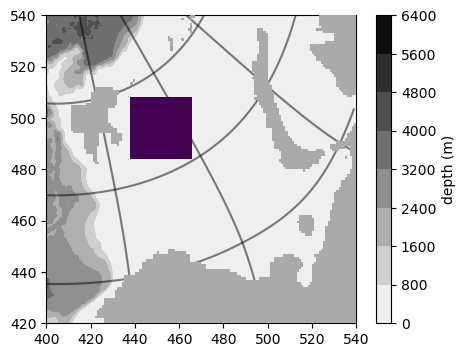

In [10]:
fig = plt.figure(figsize=(5,4))

# cb = plt.pcolormesh(get_aste_tracer(mygrid['Depth'],nfx,nfy)[0],cmap="gray_r",vmin=0,vmax=300)
cb = plt.contourf(get_aste_tracer(mygrid['Depth'],nfx,nfy)[0],cmap="gray_r")
plt.colorbar(cb,label="depth (m)")

plt.pcolormesh(get_aste_tracer(mask,nfx,nfy)[0],zorder=2)
plt.pcolormesh(get_aste_tracer(hfac,nfx,nfy)[0],zorder=4,cmap="gray_r",vmin=1,vmax=4)

plt.xlim(400,540)
plt.ylim(420,540)

xlims = np.array([420,530])
ylims = np.array([420,560])


CS = plt.contour(get_aste_tracer(lat, nfx, nfy)[0],
                 levels=np.arange(70, 90, 5),
                 colors="black", zorder=1,alpha=0.5)
CS = plt.contour(get_aste_tracer(lon, nfx, nfy)[0],
                 levels=np.arange(0, 90, 20),
                 colors="black", zorder=1,alpha=0.5)
plt.clabel(CS, inline=True, fontsize=8)

plt.savefig(path + "mask_Lind_square.png",dpi=300)

In [11]:
mymsk = mask
np.save("mask_Lind_square.npy", mask)

# load this from the file and plot the timeseries of this

In [12]:
# add the isopycnals
# add the density contours from gsw
smin = 25.5 - (0.01 * 25.5)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 36 + (0.01 * 36)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -2 + (0.1 * -2)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 31 + (0.1 * 31)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 50
ydim = 50
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(-2,31,ydim)
si = np.linspace(25.5,36,xdim)
Freez_temp = gsw.CT_freezing(si,0,0)

Si, Ti = np.meshgrid(si, ti, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        #print(si[i],ti[j])
        dens[j,i]=gsw.rho(si[i],ti[j],0)
        # Substract 1000 to convert to sigma-0
dens2 = dens - 1000

tmin, tmax, smin, smax sizes=, -2.2 34.1 25.245 36.36


In [13]:
# copy the files we need from the timeseries, make sure we know what we're looking at
# get the timesteps for the year 2007
# ocean and ice
AB_gT=0
AB_gS=0
dt_aste = 600
startyr = 2002
endyr = 2019              # for ASTE R1

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)
allyears = np.arange(2003,2018,1)

In [14]:
# np.cumsum(mygrid['DRF'][0:10])
heat_content = np.full((len(allyears),12,ny,nx),np.nan)
fw_content = np.full((len(allyears),12,ny,nx),np.nan)

In [15]:
# loop through the years to create the timeseries
# alldatetimes = np.array([])
# FW_times = np.array([])
# Heat_times = np.array([])  # this does not make sense as variable name
dstart = 0
dterm = 10

# sref = 36.25
# tref = -1.95

# from Lind Paper
sref = 35
tref = 0

iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
    SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'budg3d_snap_set2'
        meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg3d_snap_set2["fldList"])
        varnames = np.array(["THETADR","SALTDR"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        SALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m
    
        THETADR[i,:,:,:] = np.reshape(THETADRi,(nz,ny,nx))
        SALTDR[i,:,:,:] = np.reshape(SALTDRi,(nz,ny,nx))

    # get theta and salt alone so we can use for the freshwater content
    THETA = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
    SALT = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
        THETA[i,:,:,:] = THETADR[i,:,:,:]/DRF3d/hfC_modified  # degC
        SALT[i,:,:,:]  = SALTDR[i,:,:,:]/DRF3d/hfC_modified   # PSU

    ##########################################################################################
    # get the heat content
    for i in range(len(datetimes)):
        # for calculating heat content:
            # weighted theta * rcp = J/m^2 which is the depth-weighted heat content of a cell
            # integrate over all values within the depth interval of choice
        
        thisTHETA = THETADR[i]/DRF3d/mygrid['hFacC'] * mymsk[np.newaxis,:,:]    # degC
        thisheat = (thisTHETA - tref) * myparms['rcp']   # degC * J/m^3.degC = J/m^3
        thisheat = thisheat * DRF3d  # J/m³ * m = J/m²

        # select heat based on the AW layer
        thisheat = thisheat[dstart:dterm]   # upper mygrid['DRF'][:dterm] m
        heat_content_2D = np.nansum(thisheat,axis=0) * mymsk         # vertical integration (J/m^2)

        # do the spatial averaging
        # area_masked = RAC * mymsk   # m^2
        # heat_content_avg = np.nansum(heat_content_2D * area_masked)/np.nansum(area_masked)   # MJ/m^2 * m^2/m^2
        heat_content[iy,i,:,:] = heat_content_2D * 1e-6  # MJ/m^2

    ##########################################################################################
    # get the freshwater content values
    # set up for time averaging
    # filter = drf3d.copy() * mygrid['hFacC']
    # filter[filter >= 254] = np.nan
    # filter[filter < 254] = 1
    FWcontent = np.full((len(tsstr),ny,nx),np.nan)
    
    for i in range(len(tsstr)): 
        # for calculating freshwater content:
            # FW volume * (1- salinity/reference salinity)    m^3
            # integrate over surface to mygrid['DRF'][:dterm] m based on the np.where(np.cumsum(mygrid['DRF'])<X meters deep)
            # look at the time average of this
        
        # do step 1 to get FW volume and only look at the values at less than X m
        FWvol = ((sref - SALT[i])/sref) * DRF3d # m
        
        FWvol = FWvol[dstart:dterm]    # leaving as m^3 here
        
        # vertically integrate
        FWcontent_2D = np.nansum(FWvol,axis=0) * mymsk          # vertical integration, m
        # area_masked = RAC * mymsk
        # FW_content_avg = np.nansum(FWcontent_2D * area_masked)/np.nansum(area_masked)

        # add as a map to the bigger array
        fw_content[iy,i,:,:] = FWcontent_2D

    print()
    iy += 1

2003

2004

2005

2006

2007

2008

2009

2010

2011

2012

2013

2014

2015

2016

2017



In [16]:
heat_content_time = np.nanmean(heat_content,axis=(2,3))
fw_content_time = np.nanmean(fw_content,axis=(2,3))

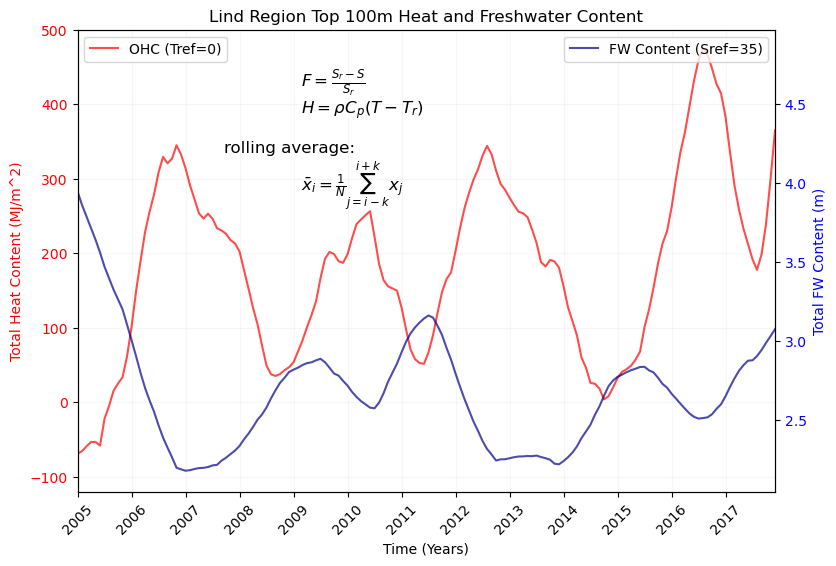

In [17]:

# Define rolling window size (12 months for seasonal smoothing)
window_size = 12

# Apply rolling mean
heat_smoothed = pd.Series(heat_content_time.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()
fw_smoothed = pd.Series(fw_content_time.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(9, 6))

# Time axis
time = np.arange(0, 15*12, 1)

# Plot smoothed heat content on primary y-axis (left)
ax1.plot(time, heat_smoothed, color="red", alpha=.7, label="OHC (Tref=0)")
ax1.set_ylabel("Total Heat Content (MJ/m^2)", color="red")
ax1.tick_params(axis='y', labelcolor="red")

# Create second y-axis for freshwater content (right)
ax2 = ax1.twinx()
ax2.plot(time, fw_smoothed, color="darkblue", alpha=.7, label="FW Content (Sref=35)")
ax2.set_ylabel("Total FW Content (m)", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")

# X-axis labels and title
ax1.set_xlabel("Time (Years)")
ax1.set_title("Lind Region Top 100m Heat and Freshwater Content")

# X-axis ticks
xtick_positions = np.arange(0, 15*12, 12)  # Every 12 months
xtick_labels = np.arange(2003, 2018)  # Years from 2004 to 2023
ax1.set_xticks(xtick_positions)
ax1.set_xticklabels(xtick_labels, rotation=45)  # Rotate for readability
ax1.set_xlim(0, 15*12)
ax1.grid(alpha=0.1)

# Add equations as text annotations
eq1 = r"$F = \frac{S_{r} - S}{S_{r}}$"
eq2 = r"$H = \rho C_p (T - T_{r})$"
eq3 = r"$\bar{x}_i = \frac{1}{N} \sum_{j=i-k}^{i+k} x_j$"  # Rolling mean equation

# Positioning the text on the plot
ax1.text(0.32, 0.92, eq1, transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='black')
ax1.text(0.32, 0.85, eq2, transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='black')
ax1.text(0.21,0.76,"rolling average:",transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='black')
ax1.text(0.32, 0.72, eq3, transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='black')  # Adjusted position


# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

ax1.set_ylim(-120,500)
ax1.set_xlim(24,time[-1])

# Show plot
# plt.savefig(path + "timeseries_OHC_Lind_smaller.png",dpi=300)
plt.show()

# add the lind trendline

In [18]:
# Lind goes from 2000-2016 ( we will only use 2006 -- 2016)
x_lind = np.arange(-36,156) # months before start of ASTE to 2016 in ASTE by months (192 months = 16 years)
y_lind = np.linspace(-180,300,192)

slope = (y_lind[-1] - y_lind[0]) / (x_lind[-1] - x_lind[0])
print(slope)

x_lind = np.arange(0,15*12)
y_lind = np.linspace(180-250,630-250,15*12)
slope = (y_lind[-1] - y_lind[0]) / (x_lind[-1] - x_lind[0])
print(slope)

2.513089005235602
2.5139664804469275


In [53]:
# Lind goes from 2000-2016 ( we will only use 2006 -- 2016)
x_lind_fw = np.arange(-36,156) # months before start of ASTE to 2016 in ASTE by months (192 months = 16 years)
y_lind_fw = np.linspace(2.1,1.5,192)

slope = (y_lind_fw[-1] - y_lind_fw[0]) / (x_lind_fw[-1] - x_lind_fw[0])
print(slope)

x_lind_fw = np.arange(0,15*12)
y_lind_fw = np.linspace(2.1+1.0,1.5+1.03,15*12)
slope = (y_lind_fw[-1] - y_lind_fw[0]) / (x_lind_fw[-1] - x_lind_fw[0])
print(slope)

-0.003141361256544503
-0.0031843575418994403


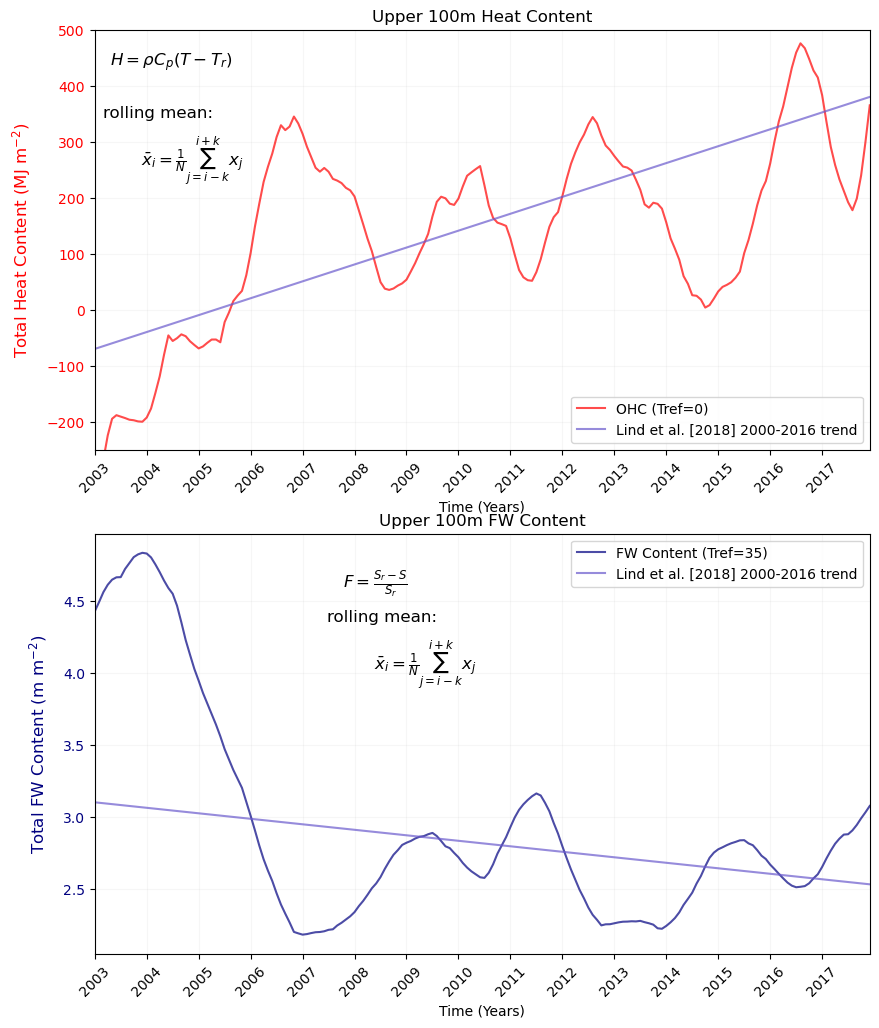

In [55]:
# remove the freshwater content and just add the heat content


# Define rolling window size (12 months for seasonal smoothing)
window_size = 12

# Apply rolling mean
heat_smoothed = pd.Series(heat_content_time.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()

# Create figure and axis
fig = plt.figure(figsize=(10,12))

ax1 = plt.subplot(211)

# Time axis
time = np.arange(0, 15*12, 1)

# Plot smoothed heat content on primary y-axis (left)
ax1.plot(time, heat_smoothed, color="red", alpha=.7, label="OHC (Tref=0)")
ax1.plot(x_lind, y_lind, color="slateblue", alpha=.7,label="Lind et al. [2018] 2000-2016 trend") #, label="OHC (Tref=0)")
ax1.set_ylabel(r"Total Heat Content (MJ m$^{-2}$)", color="red", fontsize=12, labelpad=10)
ax1.tick_params(axis='y', labelcolor="red")

# X-axis labels and title
ax1.set_xlabel("Time (Years)")
ax1.set_title("Upper 100m Heat Content")

# X-axis ticks
xtick_positions = np.arange(0, 15*12, 12)  # Every 12 months
xtick_labels = np.arange(2003, 2018)  # Years from 2004 to 2023
ax1.set_xticks(xtick_positions)
ax1.set_xticklabels(xtick_labels, rotation=45)  # Rotate for readability
ax1.set_xlim(0, 15*12)
ax1.grid(alpha=0.1)

# Add equations as text annotations
eq1 = r"$F = \frac{S_{r} - S}{S_{r}}$"
eq2 = r"$H = \rho C_p (T - T_{r})$"
eq3 = r"$\bar{x}_i = \frac{1}{N} \sum_{j=i-k}^{i+k} x_j$"  # Rolling mean equation

# Positioning the text on the plot
ax1.text(0.02, 0.95, eq2, transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='black')
ax1.text(0.01,0.82,"rolling mean:",transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='black')
ax1.text(0.06, 0.75, eq3, transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='black')  # Adjusted position


# Legends
ax1.legend(loc="lower right")

ax1.set_ylim(-250,500)
ax1.set_xlim(0,time[-1])

ax1 = plt.subplot(212)


# Time axis
time = np.arange(0, 15*12, 1)

# Plot smoothed heat content on primary y-axis (left)
ax1.plot(time, fw_smoothed, color="navy", alpha=.7, label="FW Content (Tref=35)")
ax1.plot(x_lind_fw, y_lind_fw, color="slateblue", alpha=.7,label="Lind et al. [2018] 2000-2016 trend") #, label="OHC (Tref=0)")
# ax1.plot(x_lind, y_lind, color="slateblue", alpha=.7,label="Lind et al. [2018] 2000-2016 trend") #, label="OHC (Tref=0)")
ax1.set_ylabel(r"Total FW Content (m m$^{-2}$)", color="navy", fontsize=12, labelpad=10)
ax1.tick_params(axis='y', labelcolor="navy")

ax1.text(0.32, 0.92, eq1, transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='black')

# X-axis labels and title
ax1.set_xlabel("Time (Years)")
ax1.set_title("Upper 100m FW Content")

# X-axis ticks
xtick_positions = np.arange(0, 15*12, 12)  # Every 12 months
xtick_labels = np.arange(2003, 2018)  # Years from 2004 to 2023
ax1.set_xticks(xtick_positions)
ax1.set_xticklabels(xtick_labels, rotation=45)  # Rotate for readability
ax1.set_xlim(0, 15*12)
ax1.grid(alpha=0.1)

# Add equations as text annotations
eq1 = r"$F = \frac{S_{r} - S}{S_{r}}$"
eq2 = r"$H = \rho C_p (T - T_{r})$"
eq3 = r"$\bar{x}_i = \frac{1}{N} \sum_{j=i-k}^{i+k} x_j$"  # Rolling mean equation

# Positioning the text on the plot
# ax1.text(0.02, 0.95, eq2, transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='black')
ax1.text(0.3,0.82,"rolling mean:",transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='black')
ax1.text(0.36, 0.75, eq3, transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='black')  # Adjusted position


# Legends
ax1.legend(loc="upper right")

# ax1.set_ylim(-250,500)
ax1.set_xlim(0,time[-1])


# Show plot
plt.savefig(path + "timeseries_OHC_Lind_smaller.png",dpi=300)
plt.show()

In [51]:
path

'/home/mmurakami/crios_backups/ASTE_270/Pemberton_BarentsSpaper/ASTE_figs/figs/'

In [32]:
msk1 = mymsk
# do this by looping through the salt and heat -- we want to make an average of these as depth
theta_dist1 = np.zeros((len(allyears),12,nz))
salt_dist1 = np.zeros((len(allyears),12,nz))

# do indexing in years for the layers
iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ##########################################################################################
    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
    SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'budg3d_snap_set2'
        meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg3d_snap_set2["fldList"])
        varnames = np.array(["THETADR","SALTDR"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        SALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m
    
        THETADR[i,:,:,:] = np.reshape(THETADRi,(nz,ny,nx))
        SALTDR[i,:,:,:] = np.reshape(SALTDRi,(nz,ny,nx))

    for i in range(len(datetimes)):
        # for calculating heat content:
            # weighted theta * rcp = J/m^2 which is the depth-weighted heat content of a cell
            # integrate over all values within the depth interval of choice
        # do the depth meaning for theta
        thisTHETA = THETADR[i]/DRF3d/hfC_modified * msk1[np.newaxis,:,:]    # degC
        thisTHETA[thisTHETA == 0] = np.nan   # this was messing up averaging without this precaution
        theta_dist1[iy,i,:] = np.nanmean(thisTHETA, axis = (1,2))  # depth average of shape nz

        # do the depth averaging for freshwater
        thisSALT = SALTDR[i]/DRF3d/hfC_modified * msk1[np.newaxis,:,:]    # PSU
        thisSALT[thisSALT == 0] = np.nan
        salt_dist1[iy,i,:] = np.nanmean(thisSALT, axis = (1,2))  # depth average of shape nz
    iy += 1

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [33]:
hfC_modified

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

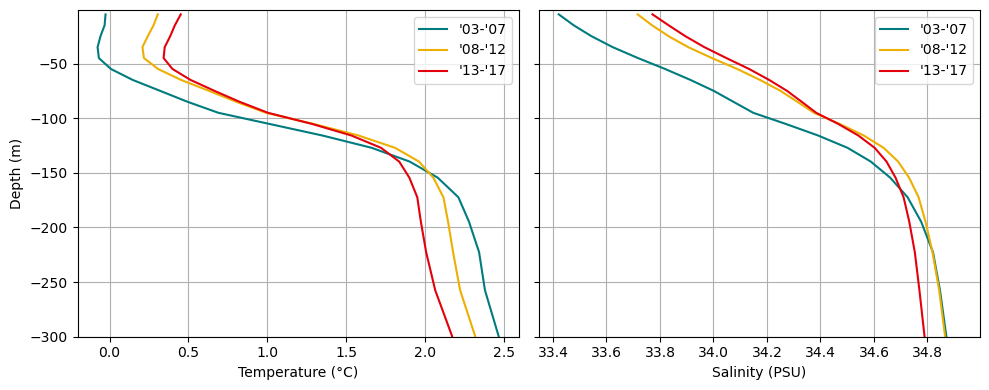

In [57]:
# colors
c1 = '#007c7e'
c2 = '#edaf02'
c3 = '#e3010c'

fig = plt.figure(figsize=(10,4))

# First plot: Temperature profile for Southern portion
ax = plt.subplot(121)

ax.plot(np.nanmean(theta_dist1[:5], axis=(0, 1)), mygrid['RC'], label="'03-'07",color=c1)
ax.plot(np.nanmean(theta_dist1[5:10], axis=(0, 1)), mygrid['RC'], label="'08-'12",color=c2)
ax.plot(np.nanmean(theta_dist1[10:], axis=(0, 1)), mygrid['RC'], label="'13-'17",color=c3)
ax.set_ylim(-300, -1)
ax.set_xlabel("Temperature (°C)")
ax.legend()
ax.grid()
ax.set_ylabel("Depth (m)")  # Y-axis label

# Second plot: Salinity profile for Southern portion
ax = plt.subplot(122)
ax.plot(np.nanmean(salt_dist1[:5], axis=(0, 1)), mygrid['RC'], label="'03-'07",color=c1)
ax.plot(np.nanmean(salt_dist1[5:10], axis=(0, 1)), mygrid['RC'], label="'08-'12",color=c2)
ax.plot(np.nanmean(salt_dist1[10:], axis=(0, 1)), mygrid['RC'], label="'13-'17",color=c3)
ax.set_ylim(-300, -1)
ax.set_xlabel("Salinity (PSU)")
ax.legend()
ax.set_yticklabels([])  # Remove tick labels
ax.set_ylabel("")  # Remove axis label
ax.grid()

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig("profiles_100m.png", dpi=300)

# print("Profiles saved to 'profiles.png'")

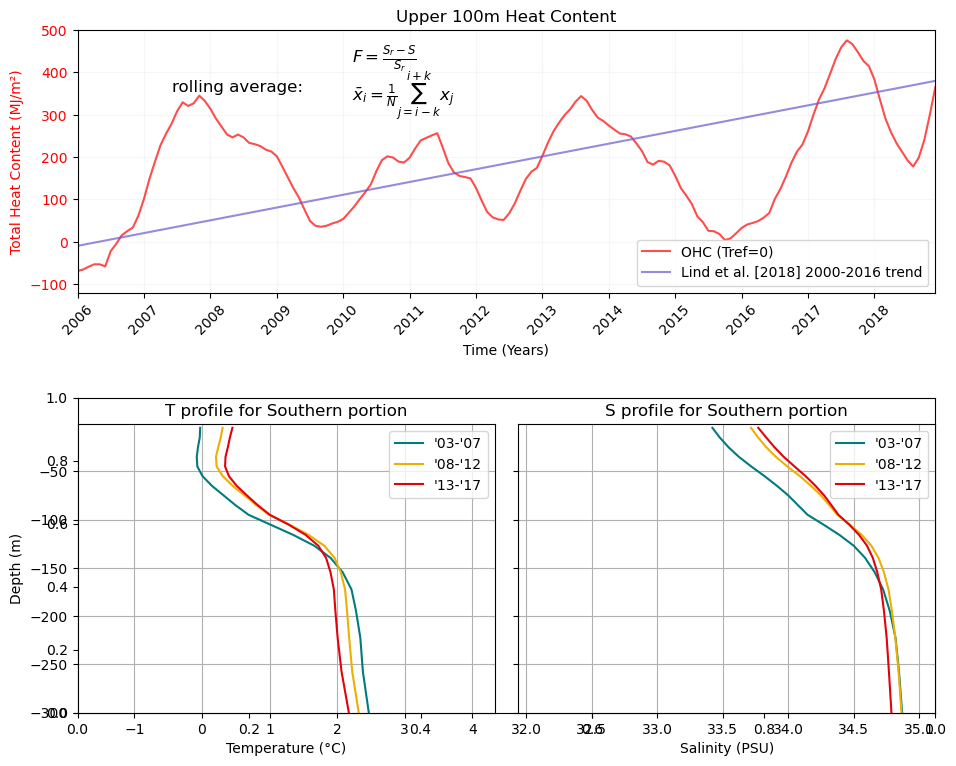

In [45]:
# plot all on one
# Define colors
c1 = '#007c7e'
c2 = '#edaf02'
c3 = '#e3010c'

# Define rolling window size (12 months for seasonal smoothing)
window_size = 12

# Apply rolling mean for heat content
heat_smoothed = pd.Series(heat_content_time.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()

# Time axis
time = np.arange(0, 15*12, 1)

# Create figure with 2 rows: wide timeseries plot + two subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [1, 1.2]})

### --- Upper Plot: Heat Content Time Series --- ###
ax1 = axes[0]

# Plot smoothed heat content
ax1.plot(time, heat_smoothed, color="red", alpha=.7, label="OHC (Tref=0)")
ax1.plot(x_lind, y_lind, color="slateblue", alpha=.7, label="Lind et al. [2018] 2000-2016 trend")

# Y-axis
ax1.set_ylabel("Total Heat Content (MJ/m²)", color="red")
ax1.tick_params(axis='y', labelcolor="red")

# X-axis labels and title
ax1.set_xlabel("Time (Years)")
ax1.set_title("Upper 100m Heat Content")

# X-axis ticks
xtick_positions = np.arange(0, 20*12, 12)  # Every 12 months
xtick_labels = np.arange(2004, 2024)  # Years from 2004 to 2023
ax1.set_xticks(xtick_positions)
ax1.set_xticklabels(xtick_labels, rotation=45)  # Rotate for readability
ax1.set_xlim(24, time[-1])
ax1.grid(alpha=0.1)

# Add equations as text annotations
eq1 = r"$F = \frac{S_{r} - S}{S_{r}}$"
eq3 = r"$\bar{x}_i = \frac{1}{N} \sum_{j=i-k}^{i+k} x_j$"  # Rolling mean equation

# Positioning the text on the plot
ax1.text(0.32, 0.95, eq1, transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='black')
ax1.text(0.11, 0.81, "rolling average:", transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='black')
ax1.text(0.32, 0.85, eq3, transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='black')

# Legends
ax1.legend(loc="lower right")

ax1.set_ylim(-120, 500)

### --- Lower Plots: Temperature & Salinity Profiles --- ###
ax2 = fig.add_subplot(2, 2, 3)  # Left plot (Temperature)
ax3 = fig.add_subplot(2, 2, 4)  # Right plot (Salinity)

# Temperature profile (Left)
ax2.plot(np.nanmean(theta_dist1[:5], axis=(0, 1)), mygrid['RC'], label="'03-'07", color=c1)
ax2.plot(np.nanmean(theta_dist1[5:10], axis=(0, 1)), mygrid['RC'], label="'08-'12", color=c2)
ax2.plot(np.nanmean(theta_dist1[10:], axis=(0, 1)), mygrid['RC'], label="'13-'17", color=c3)
ax2.set_ylim(-300, -1)
ax2.set_xlim(np.nanmin(theta_dist1), np.nanmax(theta_dist1))  # Ensure correct x-axis range
ax2.set_title("T profile for Southern portion")
ax2.legend()
ax2.grid()
ax2.set_ylabel("Depth (m)")  # Keep only on the left plot
ax2.set_xlabel("Temperature (°C)")  # Correct x-axis label

# Salinity profile (Right)
ax3.plot(np.nanmean(salt_dist1[:5], axis=(0, 1)), mygrid['RC'], label="'03-'07", color=c1)
ax3.plot(np.nanmean(salt_dist1[5:10], axis=(0, 1)), mygrid['RC'], label="'08-'12", color=c2)
ax3.plot(np.nanmean(salt_dist1[10:], axis=(0, 1)), mygrid['RC'], label="'13-'17", color=c3)
ax3.set_ylim(-300, -1)
ax3.set_xlim(np.nanmin(salt_dist1), np.nanmax(salt_dist1))  # Ensure correct x-axis range
ax3.set_title("S profile for Southern portion")
ax3.legend()
ax3.grid()
ax3.set_xlabel("Salinity (PSU)")  # Correct x-axis label

# Hide right y-axis labels (only show on left)
ax3.set_yticklabels([])  # Remove tick labels
ax3.set_ylabel("")  # Remove axis label

# Adjust layout
plt.tight_layout()

# Save the figure
# plt.savefig("combined_plot.png", dpi=300)

# Show plot
plt.show()


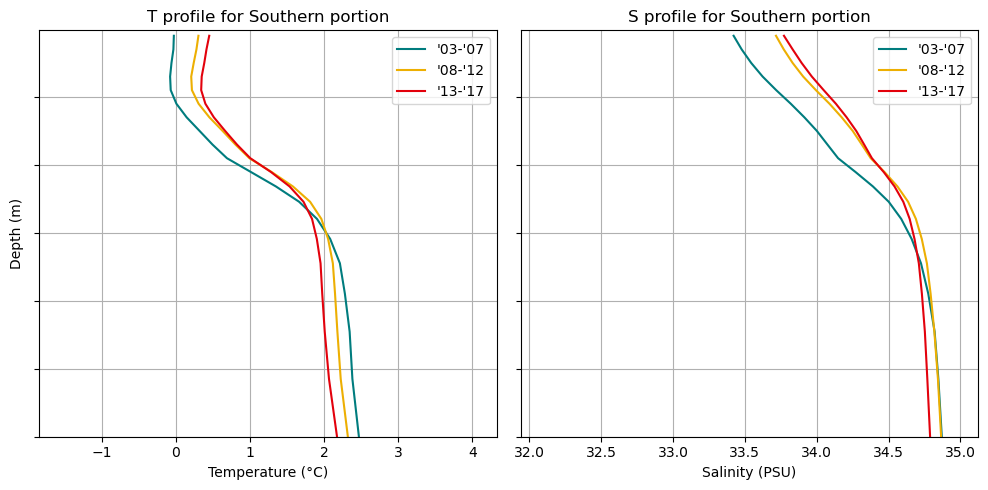

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Define colors
c1 = '#007c7e'
c2 = '#edaf02'
c3 = '#e3010c'

# Create figure with shared y-axis
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Temperature profile (Left)
ax2.plot(np.nanmean(theta_dist1[:5], axis=(0, 1)), mygrid['RC'], label="'03-'07", color=c1)
ax2.plot(np.nanmean(theta_dist1[5:10], axis=(0, 1)), mygrid['RC'], label="'08-'12", color=c2)
ax2.plot(np.nanmean(theta_dist1[10:], axis=(0, 1)), mygrid['RC'], label="'13-'17", color=c3)
ax2.set_ylim(-300, -1)
ax2.set_xlim(np.nanmin(theta_dist1), np.nanmax(theta_dist1))  # Ensure correct x-axis range
ax2.set_title("T profile for Southern portion")
ax2.legend()
ax2.grid()
ax2.set_ylabel("Depth (m)")  # Keep only on the left plot
ax2.set_xlabel("Temperature (°C)")  # Correct x-axis label

# Salinity profile (Right)
ax3.plot(np.nanmean(salt_dist1[:5], axis=(0, 1)), mygrid['RC'], label="'03-'07", color=c1)
ax3.plot(np.nanmean(salt_dist1[5:10], axis=(0, 1)), mygrid['RC'], label="'08-'12", color=c2)
ax3.plot(np.nanmean(salt_dist1[10:], axis=(0, 1)), mygrid['RC'], label="'13-'17", color=c3)
ax3.set_ylim(-300, -1)
ax3.set_xlim(np.nanmin(salt_dist1), np.nanmax(salt_dist1))  # Ensure correct x-axis range
ax3.set_title("S profile for Southern portion")
ax3.legend()
ax3.grid()
ax3.set_xlabel("Salinity (PSU)")  # Correct x-axis label

# Hide right y-axis labels (only show on left)
ax3.set_yticklabels([])  # Remove tick labels
ax3.set_ylabel("")  # Remove axis label

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig("combined_plot.png", dpi=300)

# Show plot
plt.show()


# also figure out for the latest version of ASTE

In [68]:
# copy the files we need from the timeseries, make sure we know what we're looking at
# get the timesteps for the year 2007
# ocean and ice
AB_gT=0
AB_gS=0
dt_aste = 600
startyr = 2002
endyr = 2024              # for new ASTE

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)
allyears = np.arange(2003,2024,1)

In [69]:
heat_content2 = np.full((len(allyears),12,ny,nx),np.nan)

In [70]:
# loop through the years to create the timeseries
# alldatetimes = np.array([])
# FW_times = np.array([])
# Heat_times = np.array([])  # this does not make sense as variable name
dstart = 0
dterm = 10
# sref = 36.25
# tref = -1.95

# from Lind Paper
sref = 35
tref = 0

iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
    SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'budg3d_snap_set2'
        meta_budg3d_snap_set2 = parsemeta(dirIn_new + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg3d_snap_set2["fldList"])
        varnames = np.array(["THETADR","SALTDR"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETADRi,its,meta = rdmds(os.path.join(dirIn_new, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        SALTDRi,its,meta = rdmds(os.path.join(dirIn_new, file_name),read,returnmeta=True,rec=recs[1])  # degC.m
    
        THETADR[i,:,:,:] = np.reshape(THETADRi,(nz,ny,nx))
        SALTDR[i,:,:,:] = np.reshape(SALTDRi,(nz,ny,nx))

    # get theta and salt alone so we can use for the freshwater content
    THETA = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
    SALT = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
        THETA[i,:,:,:] = THETADR[i,:,:,:]/DRF3d/mygrid['hFacC']  # degC
        SALT[i,:,:,:]  = SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC']   # PSU

    ##########################################################################################
    # get the heat content
    for i in range(len(datetimes)):
        # for calculating heat content:
            # weighted theta * rcp = J/m^2 which is the depth-weighted heat content of a cell
            # integrate over all values within the depth interval of choice
        
        thisTHETA = THETADR[i]/DRF3d/mygrid['hFacC'] * mymsk[np.newaxis,:,:]    # degC
        thisheat = (thisTHETA - tref) * myparms['rcp']   # degC * J/m^3.degC = J/m^3
        thisheat = thisheat * DRF3d  # J/m³ * m = J/m²

        # select heat based on the AW layer
        thisheat = thisheat[dstart:dterm]   # upper mygrid['DRF'][:dterm] m
        heat_content_2D = np.nansum(thisheat,axis=0) * mymsk         # vertical integration (J/m^2)

        # do the spatial averaging
        # area_masked = RAC * mymsk   # m^2
        # heat_content_avg = np.nansum(heat_content_2D * area_masked)/np.nansum(area_masked)   # MJ/m^2 * m^2/m^2
        heat_content2[iy,i,:,:] = heat_content_2D * 1e-6  # MJ/m^2

    print()
    iy += 1

2003

2004

2005

2006

2007

2008

2009

2010

2011

2012

2013

2014

2015

2016

2017

2018

2019

2020

2021

2022

2023



In [71]:
heat_content2_time = np.nanmean(heat_content2,axis=(2,3))

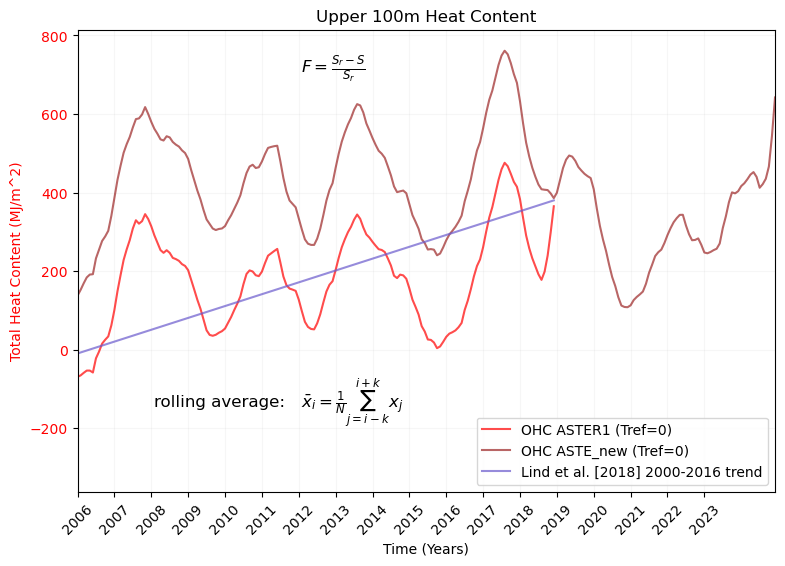

In [81]:
# remove the freshwater content and just add the heat content
# Define rolling window size (12 months for seasonal smoothing)
window_size = 12

# Apply rolling mean
heat_smoothed2 = pd.Series(heat_content2_time.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(9, 6))

# Time axis
time = np.arange(0, 15*12, 1)
time2 = np.arange(0,len(allyears)*12,1)

# Plot smoothed heat content on primary y-axis (left)
ax1.plot(time, heat_smoothed, color="red", alpha=.7, label="OHC ASTER1 (Tref=0)")
ax1.plot(time2, heat_smoothed2, color="darkred", alpha=.6, label="OHC ASTE_new (Tref=0)")
ax1.plot(x_lind, y_lind, color="slateblue", alpha=.7,label="Lind et al. [2018] 2000-2016 trend") #, label="OHC (Tref=0)")
ax1.set_ylabel("Total Heat Content (MJ/m^2)", color="red")
ax1.tick_params(axis='y', labelcolor="red")

# X-axis labels and title
ax1.set_xlabel("Time (Years)")
ax1.set_title("Upper 100m Heat Content")

# X-axis ticks
xtick_positions = np.arange(0, 20*12, 12)  # Every 12 months
xtick_labels = np.arange(2004, 2024)  # Years from 2004 to 2023
ax1.set_xticks(xtick_positions)
ax1.set_xticklabels(xtick_labels, rotation=45)  # Rotate for readability
ax1.set_xlim(0, 20*12)
ax1.grid(alpha=0.1)

# Add equations as text annotations
eq1 = r"$F = \frac{S_{r} - S}{S_{r}}$"
eq3 = r"$\bar{x}_i = \frac{1}{N} \sum_{j=i-k}^{i+k} x_j$"  # Rolling mean equation

# Positioning the text on the plot
ax1.text(0.32, 0.95, eq1, transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='black')
# ax1.text(0.11,0.81,"rolling average:",transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='black')
# ax1.text(0.32, 0.85, eq3, transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='black')  # Adjusted position
ax1.text(0.11,0.21,"rolling average:",transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='black')
ax1.text(0.32, 0.25, eq3, transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='black')  # Adjusted position


# Legends
ax1.legend(loc="lower right")

# ax1.set_ylim(-120,len(allyears)*12)
ax1.set_xlim(24,time2[-1])

# Show plot
plt.savefig(path + "timeseries_OHC_Lind_ASTE_newrun.png",dpi=300)
plt.show()

In [78]:
time

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179])